#### Imports

In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))
from importlib import reload

import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from config import FEATURES_USED_BY_CLASSIFIER
import numpy as np
import matplotlib.pyplot as plt
import math

#### Daten einlesen

In [ ]:
df = pd.read_csv('output_neu.csv')
df = df[df['stopwords_removed'] == True]
df = df[df['author'] != 'ALL']
df = df[df['fixed_token_count'] == df['fixed_token_count'].max()]
df = df[df["link_distance"] == 1 ]
# df = df[df['language'] == 'de']

# Filter für Features, die in Klassifizierung mit einbezogen werden
features = FEATURES_USED_BY_CLASSIFIER


X = df[features]
y = df['author']

# print(df)

#### Klassifikatoren erstellen, trainieren und Genauigkeit auswerten

Testdaten-Anteil: 0.25
Unterschiedliche Aufteilungen der Daten: 400
Genauigkeit: 
    Durchschnitt: 0.2532291666666666
    Minimum: 0.0
    Maximum: 0.7777777777777778
    Standardabweichung: 0.14838277093730914
Insgesamt 34 Einträge im Dataframe.


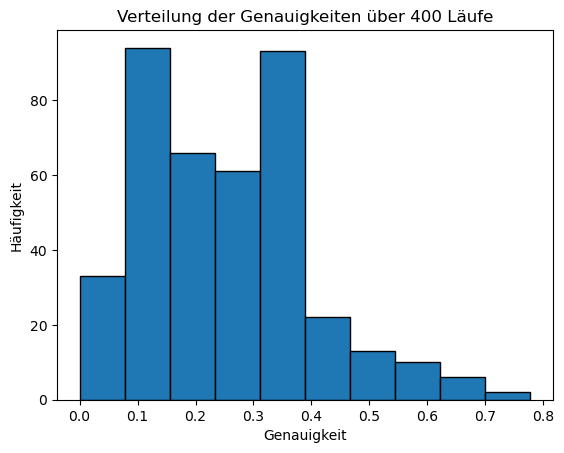

Die zwei wichtigsten Metriken: [('betweenness_min', 0.10294117647058823), ('edge_count', 0.10294117647058827)]



Testdaten-Anteil: 0.25
Unterschiedliche Aufteilungen der Daten: 400
Genauigkeit: 
    Durchschnitt: 0.5450694444444444
    Minimum: 0.0
    Maximum: 1.0
    Standardabweichung: 0.16728471919525276
Insgesamt 34 Einträge im Dataframe.


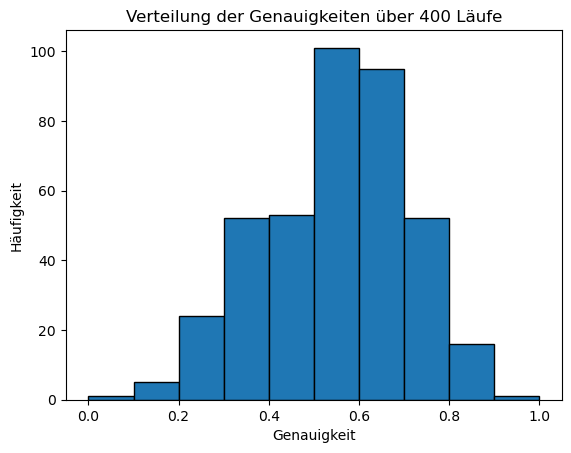

Die zwei wichtigsten Metriken: [('betweenness_standard_deviation', 0.4117647058823529), ('edge_count', 0.5176470588235293)]



Testdaten-Anteil: 0.25
Unterschiedliche Aufteilungen der Daten: 400
Genauigkeit: 
    Durchschnitt: 0.5129513888888888
    Minimum: 0.125
    Maximum: 0.8888888888888888
    Standardabweichung: 0.13106280282791155
Insgesamt 34 Einträge im Dataframe.


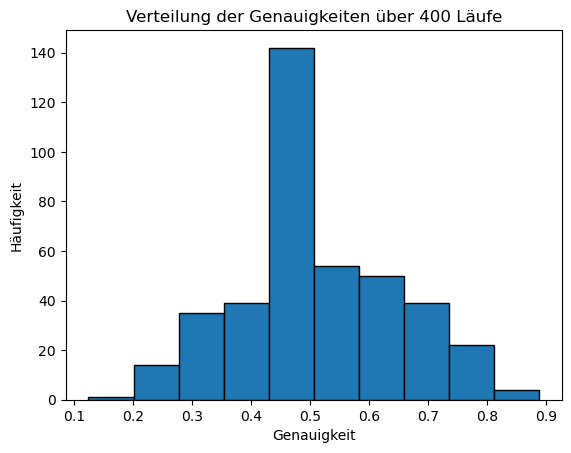

Die zwei wichtigsten Metriken: [('node_count', 0.17647058823529418), ('edge_count', 0.3764705882352941)]



Testdaten-Anteil: 0.25
Unterschiedliche Aufteilungen der Daten: 400
Genauigkeit: 
    Durchschnitt: 0.4862847222222222
    Minimum: 0.0
    Maximum: 0.875
    Standardabweichung: 0.15115766219634247
Insgesamt 34 Einträge im Dataframe.


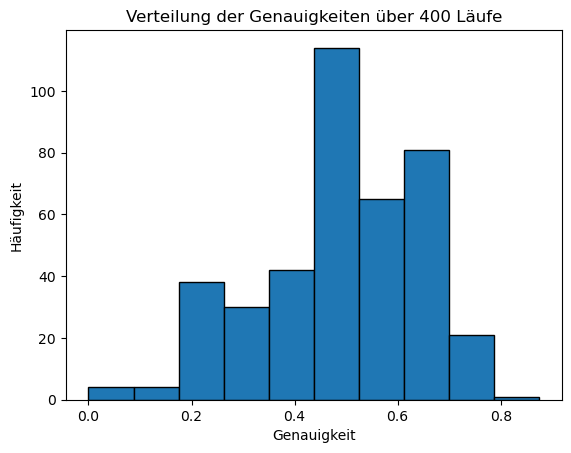

Die zwei wichtigsten Metriken: [('powerlaw_alpha_value', 0.05882352941176472), ('edge_count', 0.10882352941176472)]





In [3]:

# Je Split teilen wir die Daten auf
split_count = 4
n_repeats = 100

# Fold festlegen für Kreuzvalidierung
cv = RepeatedStratifiedKFold(n_splits=split_count, n_repeats=n_repeats, random_state=42)

classifier_list = [
    DummyClassifier(strategy='uniform'),
    DecisionTreeClassifier(), # Entscheidungsbaum
    KNeighborsClassifier(n_neighbors=5), # KNN-Algorithmus
    GaussianNB() # Naive-Bayes-Algorithmus
]

for classifier in classifier_list:

    # Bilden der Genauigkeitswerte
    accuracy_scores = cross_val_score(classifier, X, y, cv=cv)

    # Statistiken dazu ausgeben
    print(f'Testdaten-Anteil: {1 / split_count}')
    print(f'Unterschiedliche Aufteilungen der Daten: {len(accuracy_scores)}')
    print(f'Genauigkeit: ')
    print(f'    Durchschnitt: {np.mean(accuracy_scores)}')
    print(f'    Minimum: {min(accuracy_scores)}')
    print(f'    Maximum: {max(accuracy_scores)}')
    print(f'    Standardabweichung: {np.std(accuracy_scores)}')
    print(f'Insgesamt {len(df)} Einträge im Dataframe.')

    # Histogramm zu Genauigkeiten plotten
    plt.hist(accuracy_scores, bins=10, edgecolor='black')
    plt.xlabel('Genauigkeit')
    plt.ylabel('Häufigkeit')
    plt.title(f'Verteilung der Genauigkeiten über {len(accuracy_scores)} Läufe')
    plt.show()

    # Klassifikator auf alle verfügbaren Daten trainieren, damit Permutationswichtigkeit bestimmt werden kann.
    classifier.fit(X, y)

    # Bestimmung der Permutationswichtigkeit
    permutation_importance_list = permutation_importance(classifier, X, y, n_repeats=10)
    most_important_features = sorted(list(zip(features, permutation_importance_list.importances_mean)), key = lambda x: x[1])[-2:]
    print(f"Die zwei wichtigsten Metriken: {most_important_features}")
    print(f"\n\n")
